# Model Output Analysis: Conversation Topic Classifier

This notebook performs exploratory data analysis (EDA) on the AI classification outputs to evaluate model reliability, identify potential issues, and provide actionable insights for improvement.

## Notebook Structure

1. **Setup & Data Loading** - Import libraries, load dataset
2. **Gold Set Evaluation** - Compare against manual labels
3. **Topic Distribution Analysis** - Classification label patterns
4. **Confidence Analysis** - Model certainty patterns
5. **Conversation Length Analysis** - Input text characteristics
6. **Rationale Analysis** - Model explanation quality
7. **Quality Signals & Red Flags** - Potential issues
8. **Model Health Dashboard** - Summary metrics
9. **Insights & Recommendations** - Actionable findings

---
## 1. Setup & Data Loading

In [123]:
"""
Import required libraries for data analysis and visualization.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Chart export settings
EXPORT_CHARTS = False  # Set to True to save charts as PNG files
CHART_DPI = 150

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [124]:
"""
Load the model output dataset.
Expected columns: conversation_id, conversation, topic, confidence, rationale
"""
# Configuration - adjust paths as needed
AI_LABELS_PATH = "data/conversations_ai_classified.csv"
MANUAL_LABELS_PATH = 'data/conversations_ai_classified_gpt5_2_simple.csv' # "data/conversations_manually_classified.csv"

# Load AI classifications
df = pd.read_csv(AI_LABELS_PATH)

In [125]:
"""
Preview the dataset and check for basic data quality issues.
"""
# Preview first few rows
print("Sample rows:")
df.head(3)

Sample rows:


,conversation_id,conversation,topic,confidence,rationale,handler_summary,emotion,difficulty,operational_actions,risk_level,escalation_required,escalation_flags,root_cause_code,root_cause_detail
0,1,Agent: Thank you for calling BrownBox Customer Support. My name is Tom. How may I assist you tod...,Account Access & Customer Profile,high,The customer is experiencing issues logging into their account and needs assistance with verific...,Customer is unable to log in due to verification issues and needs help with email verification.,calm,low,['resend_otp_or_verification'],none,False,[],unknown_or_multi_intent,Customer may have registered with a different number.
1,2,Agent: Thank you for calling BrownBox customer support. My name is Alex. How may I assist you to...,"Returns, Refunds & Exchanges",high,"The customer is inquiring about returning a recalled product and the refund process, which clear...",Customer is asking about returning a recalled monitor and wants guidance on the return process.,calm,low,"['initiate_return', 'initiate_refund']",low,False,[],recall_or_safety_return,Monitor recalled due to technical issue.
2,3,Agent: Thank you for calling BrownBox Customer Support. My name is Sarah. How may I assist you t...,"Returns, Refunds & Exchanges",high,"The customer is requesting a replacement for a product, which falls under returns and exchanges.",Customer is unable to click the 'Cancel' button and opts for a replacement instead.,calm,medium,['initiate_exchange_replacement'],none,False,[],cancel_button_or_ui_bug,Cancel button not functioning due to a glitch.


---
## 2. Gold Set Evaluation

Compare AI classifications against manually labeled data to measure accuracy.

In [126]:
"""
Load and merge gold (manual) labels for evaluation.
"""
# Load manual classifications
manual_df = pd.read_csv(MANUAL_LABELS_PATH)

# Select and rename columns for merging
pred_df = df[['conversation_id', 'topic']].rename(columns={'topic': 'label_pred'})
true_df = manual_df[['conversation_id', 'topic']].rename(columns={'topic': 'label_true'})

# Merge and drop rows without manual labels
eval_df = true_df.merge(pred_df, on='conversation_id', how='inner')
eval_df = eval_df.dropna()

In [127]:
"""
Generate classification report comparing AI vs manual labels.
"""
print("Classification Report (AI vs Manual Labels):")
print("=" * 70)
report = classification_report(eval_df['label_true'], eval_df['label_pred'])
print(report)

# Calculate overall accuracy
accuracy = (eval_df['label_true'] == eval_df['label_pred']).mean() * 100
print(f"\nOverall Accuracy: {accuracy:.1f}%")

Classification Report (AI vs Manual Labels):
                                             precision    recall  f1-score   support

          Account Access & Customer Profile       0.90      0.96      0.93       136
     Billing, Charges & Price Discrepancies       0.95      0.84      0.89        68
Complaints, Escalations & Negative Feedback       1.00      0.21      0.35        14
           General Enquiries & Multi-Intent       0.44      0.33      0.38        12
                Orders, Shipping & Delivery       0.96      0.92      0.94       229
       Product Defects & Fulfillment Errors       0.76      0.62      0.69        72
         Product Information & Availability       0.74      0.78      0.76       119
            Promotions, Discounts & Loyalty       0.89      0.85      0.87        48
               Returns, Refunds & Exchanges       0.88      0.98      0.93       280
                Technical & Platform Issues       0.21      0.23      0.22        22

                  

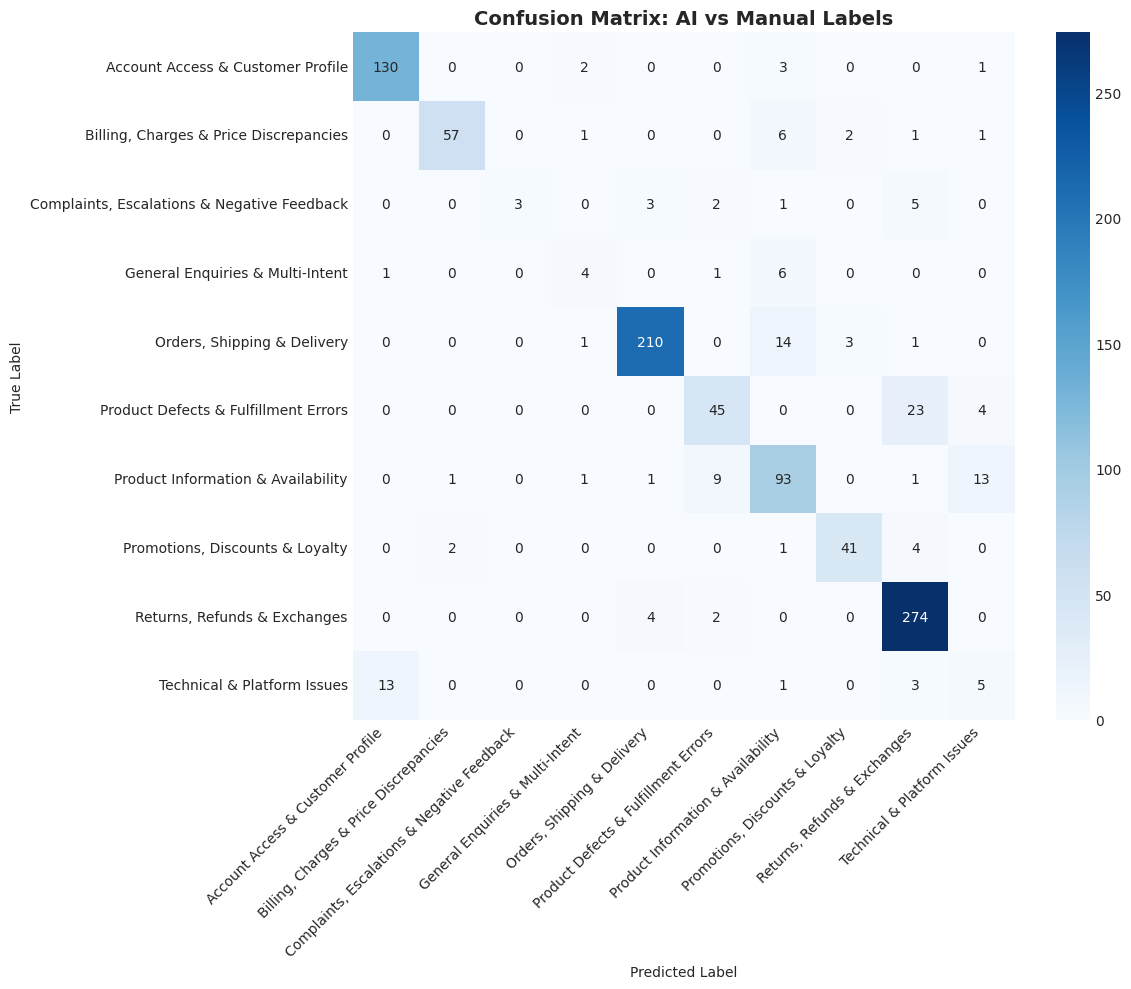

In [128]:
"""
Generate confusion matrix to identify misclassification patterns.
"""
if GOLD_SET_AVAILABLE and len(eval_df) > 0:
    # Get unique labels (sorted)
    labels = sorted(set(eval_df['label_true'].unique()) | set(eval_df['label_pred'].unique()))
    
    # Create confusion matrix
    cm = confusion_matrix(eval_df['label_true'], eval_df['label_pred'], labels=labels)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix: AI vs Manual Labels', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if EXPORT_CHARTS:
        plt.savefig('charts/confusion_matrix.png', dpi=CHART_DPI, bbox_inches='tight')
    
    plt.show()
else:
    print("Confusion matrix skipped (no manual labels available).")

In [129]:
"""
Analyze misclassifications for patterns.
"""
if GOLD_SET_AVAILABLE and len(eval_df) > 0:
    misclassified = eval_df[eval_df['label_true'] != eval_df['label_pred']]
    
    if len(misclassified) > 0:
        print(f"Misclassified conversations: {len(misclassified)} ({len(misclassified)/len(eval_df)*100:.1f}%)")
        print("\nMisclassification patterns:")
        
        # Show common misclassification pairs
        misclass_pairs = misclassified.groupby(['label_true', 'label_pred']).size().sort_values(ascending=False)
        print(misclass_pairs.head(10))
    else:
        print("✓ No misclassifications found in the gold set!")

Misclassified conversations: 138 (13.8%)

Misclassification patterns:
label_true                                   label_pred                          
Product Defects & Fulfillment Errors         Returns, Refunds & Exchanges            23
Orders, Shipping & Delivery                  Product Information & Availability      14
Product Information & Availability           Technical & Platform Issues             13
Technical & Platform Issues                  Account Access & Customer Profile       13
Product Information & Availability           Product Defects & Fulfillment Errors     9
General Enquiries & Multi-Intent             Product Information & Availability       6
Billing, Charges & Price Discrepancies       Product Information & Availability       6
Complaints, Escalations & Negative Feedback  Returns, Refunds & Exchanges             5
Promotions, Discounts & Loyalty              Returns, Refunds & Exchanges             4
Returns, Refunds & Exchanges                 Orders, Shi

---
## 3. Topic Distribution Analysis

Understanding how conversations are distributed across topic categories helps identify:
- Class imbalance issues
- Dominant vs. rare topics
- Potential taxonomy gaps

In [130]:
"""
Calculate topic distribution statistics.
"""
# Topic counts and percentages
topic_counts = df['topic'].value_counts()
topic_pcts = df['topic'].value_counts(normalize=True) * 100

topic_dist = pd.DataFrame({
    'Count': topic_counts,
    'Percentage': topic_pcts.round(1)
})

print(f"Total topics: {len(topic_counts)}")
print(f"\nTopic Distribution:")
topic_dist

Total topics: 10

Topic Distribution:


,Count,Percentage
topic,,
"Returns, Refunds & Exchanges",312,31.2
"Orders, Shipping & Delivery",218,21.8
Account Access & Customer Profile,144,14.4
Product Information & Availability,125,12.5
"Billing, Charges & Price Discrepancies",60,6.0
Product Defects & Fulfillment Errors,59,5.9
"Promotions, Discounts & Loyalty",46,4.6
Technical & Platform Issues,24,2.4
General Enquiries & Multi-Intent,9,0.9


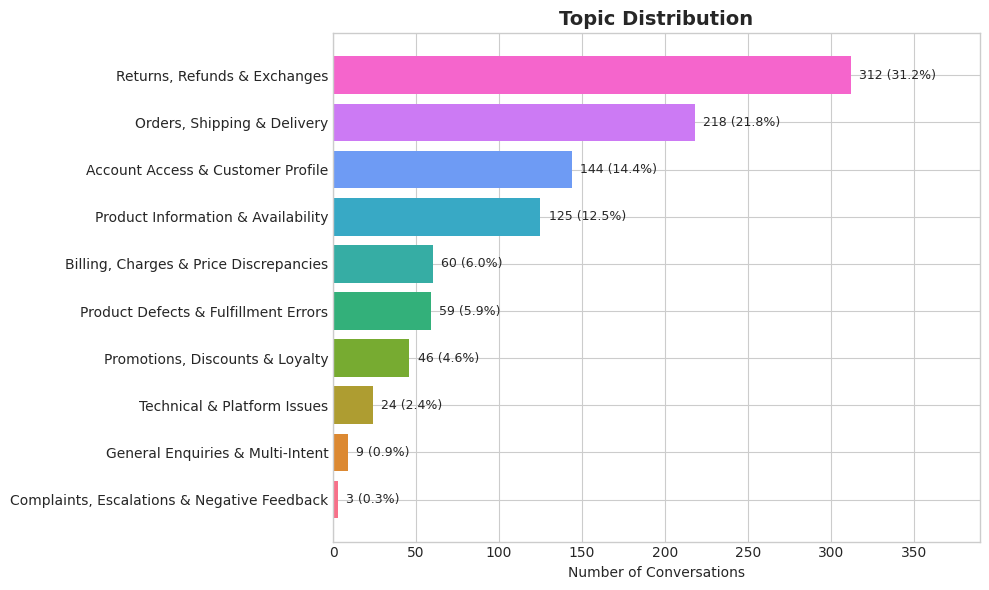

In [131]:
"""
Visualize topic distribution as a horizontal bar chart.
"""
fig, ax = plt.subplots(figsize=(10, 6))

# Sort by count for better visualization
topic_counts_sorted = topic_counts.sort_values(ascending=True)

# Create horizontal bar chart
colors = sns.color_palette('husl', len(topic_counts))
bars = ax.barh(topic_counts_sorted.index, topic_counts_sorted.values, color=colors)

# Add count labels on bars
for bar, count in zip(bars, topic_counts_sorted.values):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
            f'{count} ({count/len(df)*100:.1f}%)', 
            va='center', fontsize=9)

ax.set_xlabel('Number of Conversations')
ax.set_title('Topic Distribution', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(topic_counts_sorted.values) * 1.25)  # Leave room for labels

plt.tight_layout()

if EXPORT_CHARTS:
    plt.savefig('charts/topic_distribution.png', dpi=CHART_DPI, bbox_inches='tight')
    
plt.show()

---
## 4. Confidence Analysis

Analyzing confidence levels helps understand:
- Overall model certainty
- Which topics are harder to classify
- Potential ambiguity in the taxonomy

In [132]:
"""
Overall confidence level distribution.
"""
# Confidence counts
conf_counts = df['confidence'].value_counts().reindex(['high', 'medium', 'low']).fillna(0).astype(int)
conf_pcts = (conf_counts / len(df) * 100).round(1)

conf_summary = pd.DataFrame({
    'Count': conf_counts,
    'Percentage': conf_pcts
})

print("Overall Confidence Distribution:")
conf_summary

Overall Confidence Distribution:


,Count,Percentage
confidence,,
high,984,98.4
medium,13,1.3
low,3,0.3


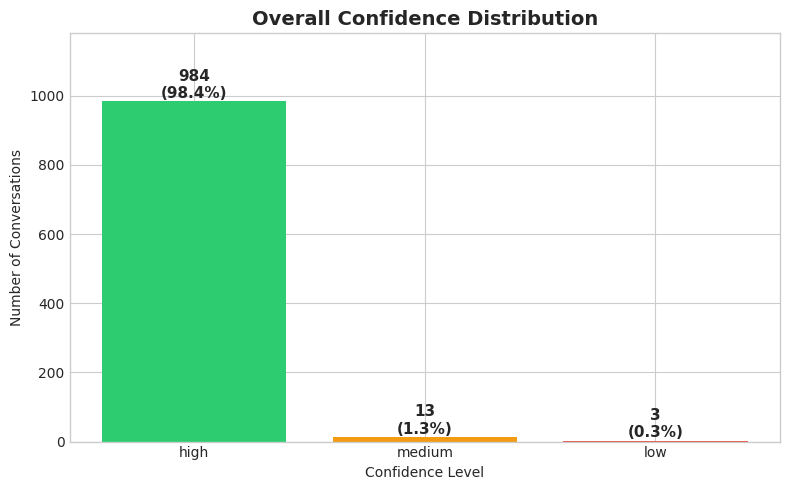

In [133]:
"""
Visualize overall confidence distribution.
"""
fig, ax = plt.subplots(figsize=(8, 5))

colors = {'high': '#2ecc71', 'medium': '#f39c12', 'low': '#e74c3c'}
bars = ax.bar(conf_counts.index, conf_counts.values, 
              color=[colors.get(c, 'gray') for c in conf_counts.index])

# Add count labels on bars
for bar, count, pct in zip(bars, conf_counts.values, conf_pcts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            f'{count}\n({pct}%)', ha='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Confidence Level')
ax.set_ylabel('Number of Conversations')
ax.set_title('Overall Confidence Distribution', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(conf_counts.values) * 1.2)

plt.tight_layout()

if EXPORT_CHARTS:
    plt.savefig('charts/confidence_distribution.png', dpi=CHART_DPI, bbox_inches='tight')
    
plt.show()

In [134]:
"""
Confidence distribution broken down by topic.
"""
# Cross-tabulation of topic x confidence
conf_by_topic = pd.crosstab(df['topic'], df['confidence'])

# Ensure all confidence levels are present
for col in ['high', 'medium', 'low']:
    if col not in conf_by_topic.columns:
        conf_by_topic[col] = 0
conf_by_topic = conf_by_topic[['high', 'medium', 'low']]

# Calculate percentages
conf_by_topic_pct = conf_by_topic.div(conf_by_topic.sum(axis=1), axis=0) * 100

print("Confidence Distribution by Topic (counts):")
conf_by_topic

Confidence Distribution by Topic (counts):


confidence,high,medium,low
topic,,,
Account Access & Customer Profile,144,0,0
"Billing, Charges & Price Discrepancies",60,0,0
"Complaints, Escalations & Negative Feedback",3,0,0
General Enquiries & Multi-Intent,2,4,3
"Orders, Shipping & Delivery",218,0,0
Product Defects & Fulfillment Errors,59,0,0
Product Information & Availability,121,4,0
"Promotions, Discounts & Loyalty",45,1,0
"Returns, Refunds & Exchanges",311,1,0


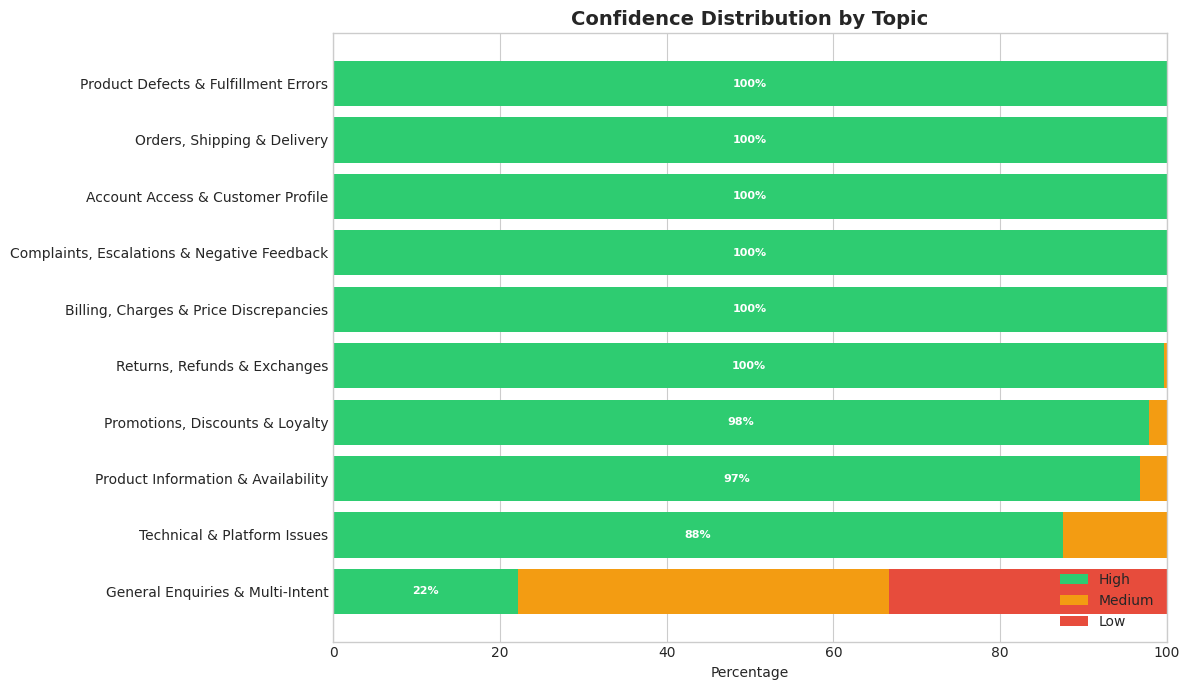

In [135]:
"""
Stacked bar chart showing confidence levels per topic.
"""
fig, ax = plt.subplots(figsize=(12, 7))

# Sort topics by high-confidence rate (descending)
topic_order = conf_by_topic_pct['high'].sort_values(ascending=True).index
conf_by_topic_sorted = conf_by_topic_pct.reindex(topic_order)

# Create stacked horizontal bar chart
colors = {'high': '#2ecc71', 'medium': '#f39c12', 'low': '#e74c3c'}

left = np.zeros(len(conf_by_topic_sorted))
for conf_level in ['high', 'medium', 'low']:
    values = conf_by_topic_sorted[conf_level].values
    ax.barh(conf_by_topic_sorted.index, values, left=left, 
            label=conf_level.capitalize(), color=colors[conf_level])
    left += values

ax.set_xlabel('Percentage')
ax.set_title('Confidence Distribution by Topic', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim(0, 100)

# Add percentage labels for high confidence
for i, topic in enumerate(conf_by_topic_sorted.index):
    high_pct = conf_by_topic_sorted.loc[topic, 'high']
    if high_pct > 10:  # Only show label if there's enough space
        ax.text(high_pct/2, i, f'{high_pct:.0f}%', ha='center', va='center', 
                fontsize=8, color='white', fontweight='bold')

plt.tight_layout()

if EXPORT_CHARTS:
    plt.savefig('charts/confidence_by_topic.png', dpi=CHART_DPI, bbox_inches='tight')
    
plt.show()

In [136]:
"""
Topics with lowest confidence (most medium/low classifications).
These may indicate taxonomy ambiguity or classification difficulty.
"""
# Calculate low+medium confidence rate
low_med_rate = (conf_by_topic_pct['low'] + conf_by_topic_pct['medium']).sort_values(ascending=False)

low_conf_df = pd.DataFrame({
    'Topic': low_med_rate.index,
    'Low+Medium Rate (%)': low_med_rate.values.round(1),
    'Low (%)': conf_by_topic_pct['low'].reindex(low_med_rate.index).values.round(1),
    'Medium (%)': conf_by_topic_pct['medium'].reindex(low_med_rate.index).values.round(1),
    'Total': conf_by_topic.sum(axis=1).reindex(low_med_rate.index).values
}).reset_index(drop=True)

print("⚠️  Topics with Lowest Confidence (potential issues):")
low_conf_df.head(5)

⚠️  Topics with Lowest Confidence (potential issues):


,Topic,Low+Medium Rate (%),Low (%),Medium (%),Total
0,General Enquiries & Multi-Intent,77.8,33.3,44.4,9
1,Technical & Platform Issues,12.5,0.0,12.5,24
2,Product Information & Availability,3.2,0.0,3.2,125
3,"Promotions, Discounts & Loyalty",2.2,0.0,2.2,46
4,"Returns, Refunds & Exchanges",0.3,0.0,0.3,312
